<a href="https://colab.research.google.com/github/Mohith200023/AI_Interview_Assist/blob/main/Interview_Prep_6/interview_prep_simulation_scenarios_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Time Series, Forecasting & Agentic Pipelines

VEPANJERI SAI MOHITH REDDY

NOT YOUR ID

**Topics Covered:** Time Series Analysis · Autoregression · ARIMA · Prophet · Sklearn Lag Models · Smolagents · GROQ · HuggingFace

**Libraries:** `yfinance` · `statsmodels` · `sklearn` · `prophet` · `smolagents` · `groq` · `huggingface_hub`

> 🎯 **Learning Goal:** By the end of this notebook you will have built a full forecasting pipeline — from raw financial data to a working AI agent that analyzes and narrates your results — skills directly applicable in industry interviews and production systems.

---
### 🗺️ Notebook Roadmap
| Section | Topic | Style |
|---------|-------|-------|
| 1 | Environment Setup | Guided |
| 2 | Data Acquisition & EDA | Fill-in-the-blank |
| 3 | Stationarity, Decomposition & Autocorrelation | Fill-in-the-blank |
| 4 | ARIMA with `statsmodels` | Fill-in-the-blank → Complete |
| 5 | Lag-Feature Regression with `sklearn` | Guided → Complete |
| 6 | Forecasting with `Prophet` | Complete + Discussion |
| 7 | Agentic Pipeline with Smolagents + GROQ + HuggingFace | Complete + Discussion |


## Getting Started

* Edit Your Name
* Automatic 0 if you include your student id or any other id
* Name the file Your_Name.ipynb
* Share the link with Anyone with link and Edit privileges
* Get your Groq API key and HuggingFace token and put them in Colab secrets

> **Setup task:** Sign up at [console.groq.com](https://console.groq.com) and [huggingface.co/settings/tokens](https://huggingface.co/settings/tokens) for free API keys.

---
## Section 1 — Environment Setup 🛠️

Before we do any data science, we need a clean, reproducible environment. This mirrors industry practice — every production ML project starts with dependency management.

Run the cell below to install all required libraries. If you are on a shared server or Colab, this may take a minute.


In [1]:
# Install all required packages
# Run this cell first — then restart the kernel if prompted

import subprocess, sys

packages = [
    "yfinance",
    "statsmodels",
    "scikit-learn",
    "prophet",
    "smolagents",
    "groq",
    "huggingface_hub",
    "plotly",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
]

for pkg in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

print("✅ All packages installed successfully.")


✅ All packages installed successfully.


In [2]:
# ── Core Imports ──────────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Time series specific
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly

# API clients
from groq import Groq
from huggingface_hub import InferenceClient

# Smolagents
from smolagents import tool, CodeAgent, InferenceClientModel

# Display settings
pd.set_option("display.float_format", "{:.4f}".format)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

print("✅ All imports successful.")
print(f"   pandas  : {pd.__version__}")
print(f"   numpy   : {np.__version__}")


✅ All imports successful.
   pandas  : 2.2.2
   numpy   : 2.0.2


### 🔑 API Key Setup

We are using two free API providers:

- **GROQ** — blazing-fast LLM inference (free tier, no credit card required). Sign up at [console.groq.com](https://console.groq.com)
- **HuggingFace** — free inference API for open-source models. Get your token at [huggingface.co/settings/tokens](https://huggingface.co/settings/tokens)

> ⚠️ **Never hardcode API keys in a notebook you share.** Use environment variables or Colab secrets in production. For this workshop we will enter them interactively.


In [6]:
import os
import getpass
from google.colab import userdata

# ── Set your API keys ─────────────────────────────────────────────────────────
# Option A: Enter interactively (recommended for class)
if "GROQ_API_KEY" not in os.environ:
    # os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your GROQ API key: ")
    os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

if "HF_TOKEN" not in os.environ:
    # os.environ["HF_TOKEN"] = getpass.getpass("Enter your HuggingFace token: ")
    os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

# Option B: Use environment variables

GROQ_API_KEY = os.environ["GROQ_API_KEY"]
HF_TOKEN     = os.environ["HF_TOKEN"]

print("✅ API keys loaded.")
print("   GROQ key starts with:", GROQ_API_KEY[:8], "...")
print("   HF   key starts with:", HF_TOKEN[:8], "...")


✅ API keys loaded.
   GROQ key starts with: gsk_qIEQ ...
   HF   key starts with: hf_xiKBZ ...


---
## Section 2 — Data Acquisition & Exploratory Analysis 📊

We will work with **Apple Inc. (AAPL)** daily closing prices — a real financial time series that is non-stationary, seasonally influenced, and rich with structure. This is exactly the kind of data you will encounter in quantitative finance, data engineering, and ML engineering roles.




### 2.1 Download the Data

`yfinance` is a widely used open-source library that fetches market data from Yahoo Finance. It returns a `pandas DataFrame` — the standard data structure you will use in almost every data science role.

In [7]:
# ── 2.1 Download financial data ────────────────────────────────────────────────

TICKER    = "AAPL"       # Try "SPY", "MSFT", "TSLA" for variety
START     = "2018-01-01"
END       = "2024-12-31"
FALLBACK  = "aapl_fallback.csv"   # Will be created below as backup

try:
    raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
    if raw.empty:
        raise ValueError("Empty response from yfinance")
    raw.to_csv(FALLBACK)           # Cache locally as fallback
    print(f"✅ Downloaded {len(raw)} rows from Yahoo Finance.")
except Exception as e:
    print(f"⚠️  yfinance failed ({e}). Loading fallback CSV.")
    raw = pd.read_csv(FALLBACK, index_col=0, parse_dates=True)

# Work with the closing price only
df = raw[["Close"]].copy()
df.columns = ["price"]
df.index = pd.to_datetime(df.index)
df.index.name = "date"

print(f"\nDataset shape : {df.shape}")
print(f"Date range    : {df.index.min().date()} → {df.index.max().date()}")
df.head(10)


✅ Downloaded 1760 rows from Yahoo Finance.

Dataset shape : (1760, 1)
Date range    : 2018-01-02 → 2024-12-30


,price
date,
2018-01-02,40.3042
2018-01-03,40.2972
2018-01-04,40.4843
2018-01-05,40.9453
2018-01-08,40.7932
2018-01-09,40.7885
2018-01-10,40.7791
2018-01-11,41.0108
2018-01-12,41.4343


### 2.2 Fill-in-the-Blank: Basic Exploration

> 📝 **Exercise** — Complete the cells below. Replace every `___` with the correct value or method call.  
> Hint: use pandas methods like `.describe()`, `.isnull()`, `.resample()`.


In [8]:
# ── 2.2a Summary statistics ───────────────────────────────────────────────────
# FILL IN: call the pandas method that returns count, mean, std, min, max, etc.

summary = df["price"].describe()
print(summary)


count   1760.0000
mean     121.6641
std       59.0018
min       33.7681
25%       54.0268
50%      131.2939
75%      168.4944
max      257.6127
Name: price, dtype: float64


In [9]:
# ── 2.2b Check for missing values ────────────────────────────────────────────
# FILL IN: count how many nulls are in the price column
missing = df["price"].isnull().sum()
df["price"] = df["price"].ffill()
print(f"Missing values: {missing}")
print("After fill:", df["price"].isnull().sum(), "missing values remain.")

Missing values: 0
After fill: 0 missing values remain.


In [11]:
# ── 2.2c Monthly average price ────────────────────────────────────────────────
# FILL IN: resample to monthly frequency and compute the mean
# Hint: df["price"].resample("___").mean()

monthly = df["price"].resample("M").mean()
print(monthly.tail(12))


date
2024-01-31   185.7942
2024-02-29   183.0379
2024-03-31   171.1390
2024-04-30   168.0749
2024-05-31   184.7794
2024-06-30   204.6802
2024-07-31   222.8749
2024-08-31   220.1138
2024-09-30   222.2977
2024-10-31   228.5547
2024-11-30   226.5117
2024-12-31   247.9137
Freq: ME, Name: price, dtype: float64


### 2.3 Visualization

Good visualization is the first thing any analyst does with a new time series. We want to see trend, volatility, and any obvious structural breaks.


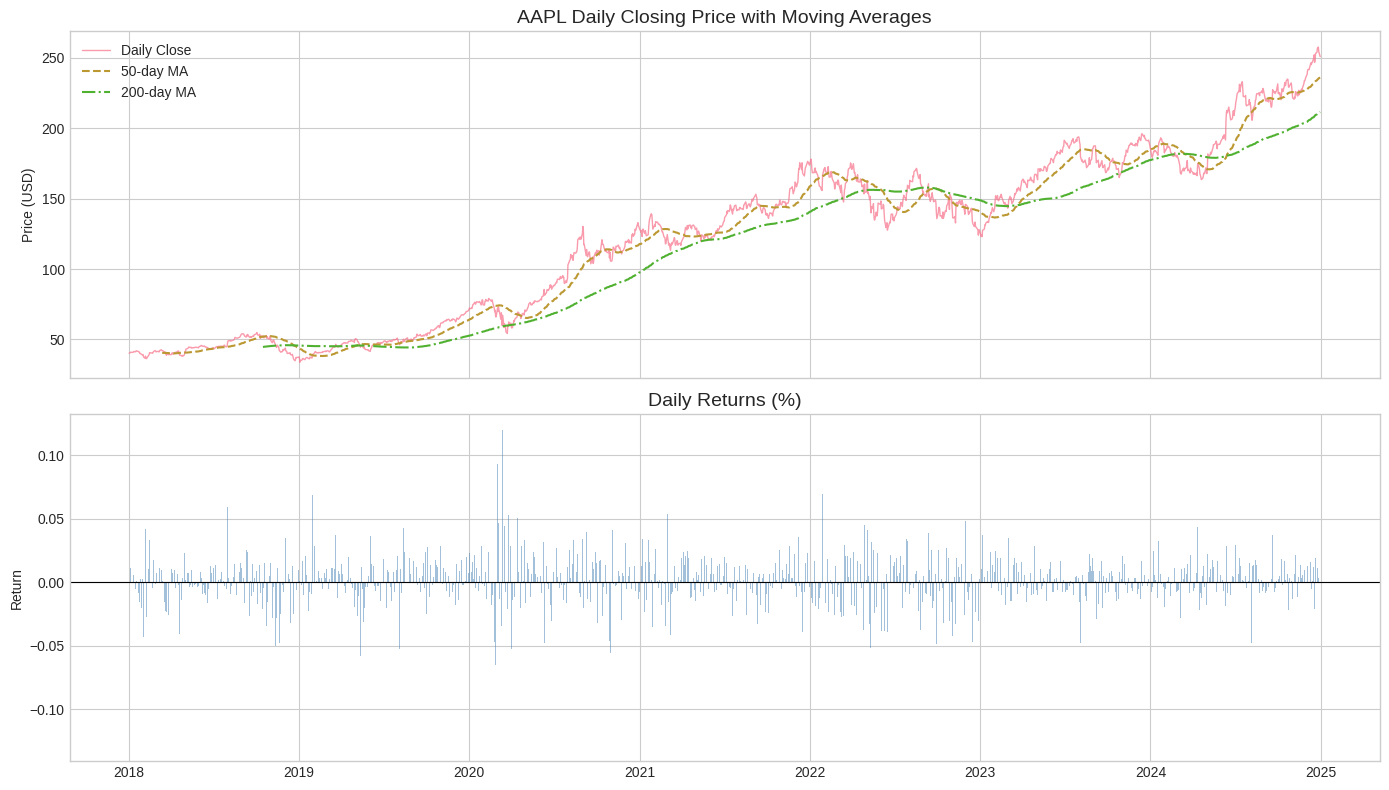

Chart saved.


In [12]:
# ── 2.3 Full price history + 50-day & 200-day moving averages ─────────────────

df["MA50"]  = df["price"].rolling(window=50).mean()
df["MA200"] = df["price"].rolling(window=200).mean()

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel — price with moving averages
axes[0].plot(df.index, df["price"], label="Daily Close", alpha=0.7, linewidth=1)
axes[0].plot(df.index, df["MA50"],  label="50-day MA",   linewidth=1.5, linestyle="--")
axes[0].plot(df.index, df["MA200"], label="200-day MA",  linewidth=1.5, linestyle="-.")
axes[0].set_title(f"{TICKER} Daily Closing Price with Moving Averages", fontsize=14)
axes[0].set_ylabel("Price (USD)")
axes[0].legend()

# Bottom panel — daily returns
df["returns"] = df["price"].pct_change()
axes[1].bar(df.index, df["returns"], alpha=0.5, color="steelblue", width=1)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_title("Daily Returns (%)", fontsize=14)
axes[1].set_ylabel("Return")
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.savefig("aapl_overview.png", dpi=150)
plt.show()
print("Chart saved.")


### 💬 Discussion Question 2A
> Look at the chart above.
> 1. Can you identify any obvious trend? Is this series stationary? What does that mean for modeling?
> 2. What do you notice about the distribution of daily returns — does it look normal? Why does this matter for financial models?
> 3. The 50-day and 200-day moving average crossover is a classic trading signal (the "Golden Cross"). Can you spot one in the chart? Would you use this as a feature in a predictive model?

**Write your answers below (double-click this cell to edit):**

1. Yes, there is a visible trend of increasing values over time. There is a significant increase in stock price from 2018 to 2024. There are visible changes or shifts in stock price, for example, when it drops sharply in 2020 and then goes back up. Thus, it is non-stationary because its mean is not constant over time, and its variance is changing too.

    From the perspective of modeling, it means that we cannot use models like ARIMA directly without transforming our data. It is because most models assume that data is stationary, and here we clearly see that it is not.

2. The daily returns vary around zero and seem much more stationary than the prices. However, the distribution does not seem perfectly normal:

	• There are large spikes in the distribution.

	• Volatility clustering is also visible.

	• The distribution is likely to show a high level of kurtosis and possibly skewness.

    The importance of normality assumptions:
    Many traditional models used in finance are based on the normal distribution. However, in the real world, financial returns are heavy-tailed, indicating that extreme events are more likely than the normal distribution would suggest.

3. Yes, a Golden Cross is when MA50 crosses above MA200. This happens after major bear markets.
Although this is a well-known technical trading signal, I would not use it as a predictive feature. However, I would consider including:

    •The distance between MA50 and MA200

    •	A binary crossover indicator

    •	Rolling momentum features
    in a machine learning model.

    It should be noted that these indicators tend to be lagging indicators, so it is best to use them as additional features instead of as a predictor.


---
## Section 3 — Stationarity, Decomposition & Autocorrelation 🔬

This section covers the **diagnostic layer** of time series analysis — the work that happens before any model is fit. These concepts come up constantly in technical interviews.

### Key Concepts

| Concept | Definition | Why It Matters |
|---------|-----------|----------------|
| **Stationarity** | Statistical properties (mean, variance) are constant over time | Most classical models assume it |
| **Decomposition** | Splitting a series into Trend + Seasonality + Residual | Reveals structure, aids model selection |
| **Autocorrelation (ACF)** | Correlation of a series with its own lagged values | Tells you how far back to look |
| **Partial Autocorrelation (PACF)** | ACF after removing shorter-lag effects | Helps select AR order |
| **ADF Test** | Augmented Dickey-Fuller — formal test for unit root (non-stationarity) | p < 0.05 → stationary |

### 3.1 Fill-in-the-Blank: Stationarity Test


In [14]:
# ── 3.1 Augmented Dickey-Fuller Test ──────────────────────────────────────────
# The ADF test checks: H0 = series has a unit root (non-stationary)
#                      H1 = series is stationary
# If p-value < 0.05 → reject H0 → series is stationary

def adf_report(series, label="Series"):
    """Run ADF test and print a clean report."""
    result = adfuller(series.dropna())
    print(f"\n{'='*50}")
    print(f"ADF Test: {label}")
    print(f"{'='*50}")
    print(f"  Test Statistic : {result[0]:.4f}")
    print(f"  p-value        : {result[1]:.6f}")
    print(f"  Lags Used      : {result[2]}")
    print(f"  Critical Values:")
    for key, val in result[4].items():
        print(f"    {key}: {val:.4f}")
    conclusion = "✅ STATIONARY (reject H0)" if result[1] < 0.05 else "❌ NON-STATIONARY (fail to reject H0)"
    print(f"  Conclusion     : {conclusion}")
    return result[1]

# FILL IN: test the raw price series
p_raw = adf_report(df["price"], label="AAPL Raw Price")



ADF Test: AAPL Raw Price
  Test Statistic : 0.0830
  p-value        : 0.964881
  Lags Used      : 0
  Critical Values:
    1%: -3.4341
    5%: -2.8632
    10%: -2.5676
  Conclusion     : ❌ NON-STATIONARY (fail to reject H0)


In [16]:
# ── 3.2 Make the series stationary through differencing ──────────────────────
# First-order differencing: removes trend by computing day-over-day change
# This is the "I" in ARIMA (Integrated)

# FILL IN: compute the first difference of the price column
df["price_diff"] = df["price"].diff(periods=1)   # Hint: .diff(1)

p_diff = adf_report(df["price_diff"].dropna(), label="AAPL First Difference")

print(f"\nConclusion: Raw series p={p_raw:.4f} vs Differenced series p={p_diff:.6f}")



ADF Test: AAPL First Difference
  Test Statistic : -42.5065
  p-value        : 0.000000
  Lags Used      : 0
  Critical Values:
    1%: -3.4341
    5%: -2.8632
    10%: -2.5676
  Conclusion     : ✅ STATIONARY (reject H0)

Conclusion: Raw series p=0.9649 vs Differenced series p=0.000000


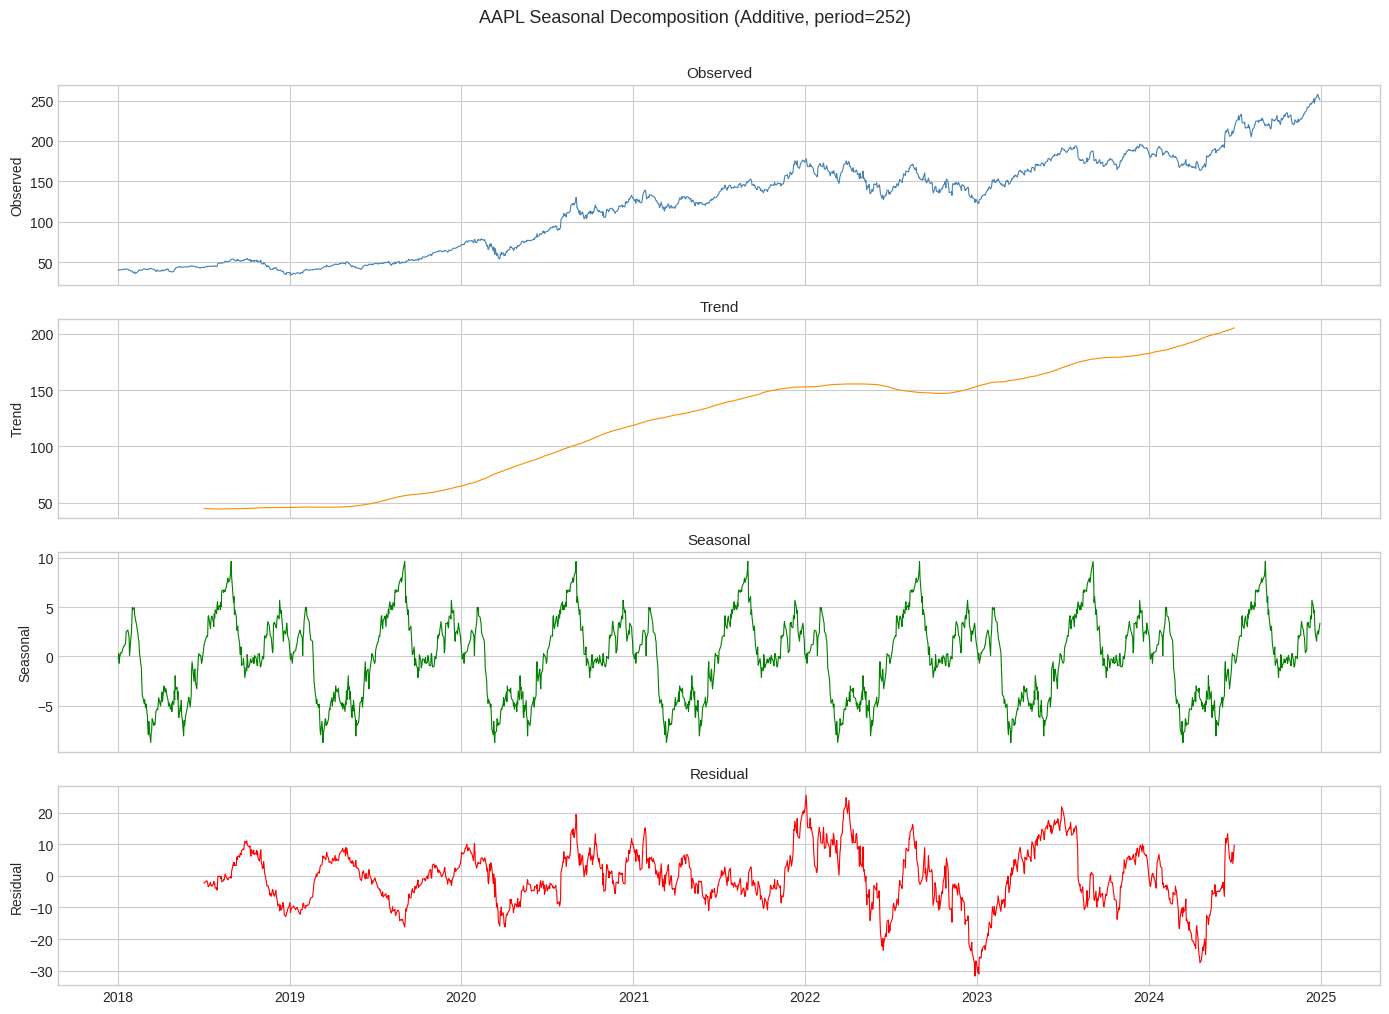

In [17]:
# ── 3.3 Seasonal Decomposition ───────────────────────────────────────────────
# We use an additive model: price = Trend + Seasonality + Residual
# period=252 ≈ trading days in a year

decomp = seasonal_decompose(df["price"].dropna(), model="additive", period=252)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
components = {
    "Observed"   : decomp.observed,
    "Trend"      : decomp.trend,
    "Seasonal"   : decomp.seasonal,
    "Residual"   : decomp.resid,
}

colors = ["steelblue", "darkorange", "green", "red"]
for ax, (name, data), color in zip(axes, components.items(), colors):
    ax.plot(data, color=color, linewidth=0.8)
    ax.set_ylabel(name)
    ax.set_title(name, fontsize=11)

axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.suptitle(f"{TICKER} Seasonal Decomposition (Additive, period=252)", fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


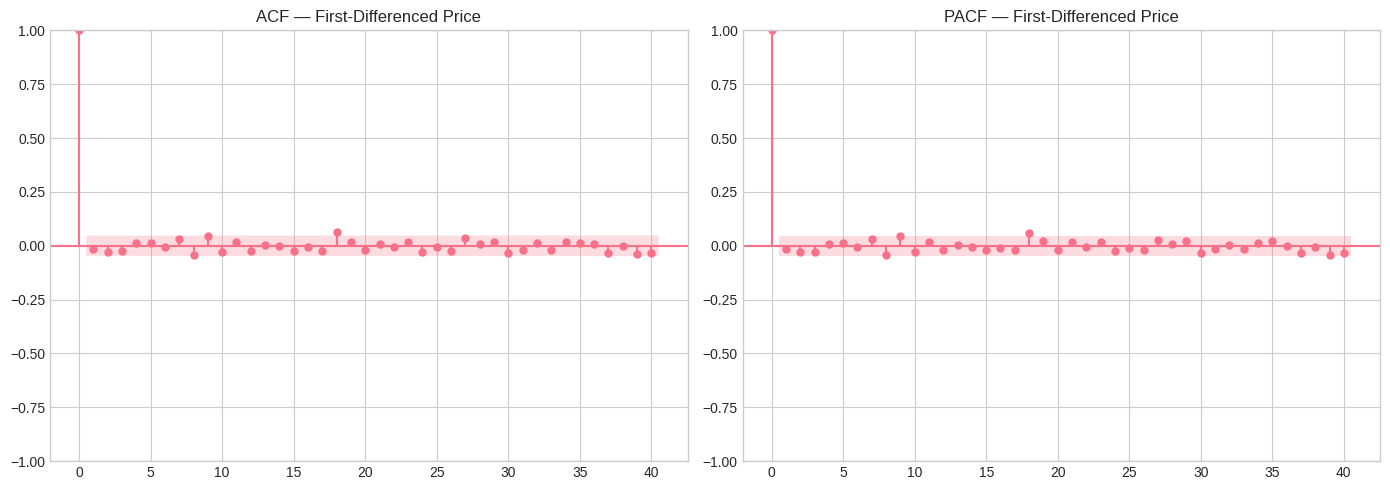

In [18]:
# ── 3.4 ACF and PACF Plots ───────────────────────────────────────────────────
# ACF  → tells us how many MA (q) terms to include
# PACF → tells us how many AR (p) terms to include
# Rule of thumb: cut-off lags are where bars cross the confidence band

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(df["price_diff"].dropna(),  lags=40, ax=axes[0],
         title="ACF — First-Differenced Price", alpha=0.05)
plot_pacf(df["price_diff"].dropna(), lags=40, ax=axes[1],
         title="PACF — First-Differenced Price", alpha=0.05, method="ywm")

plt.tight_layout()
plt.show()


### 💬 Discussion Question 3A
> 1. The raw price series failed the ADF test but the differenced series passed. Explain in plain English why differencing makes a series stationary and what information is lost when you do it.
> 2. Looking at the ACF and PACF plots of the differenced series, what values of p (AR order) and q (MA order) would you propose for an ARIMA model? Justify your answer.
> 3. The seasonal decomposition used `period=252`. Why 252? What would you change if you were working with hourly data instead of daily data?

**Write your answers below:**

1. Differencing eliminates the trend by expressing the data as the change between consecutive observations. In stock price data, random shocks are permanent, which is known as random walk. A random walk has a unit root, causing non-stationarity. Differencing eliminates the random walk, which stabilizes the data.

    However, by differencing the data, we lose information regarding absolute price levels. Differencing stock price data is equivalent to no longer analyzing absolute price levels; it is equivalent to analyzing price movement. Long-run growth is no longer part of the data.

2. From the plots:

    •	The ACF plot for the differenced series does not indicate strong significant spikes for any lag after 0.

    •	The PACF plot does not indicate a sharp cut-off for any early lags.

    •	The majority of the values fall within the confidence intervals.

    It appears that the series has weak autocorrelation in the differenced series. A good starting point for a model would be:
    ARIMA(0,1,0), i.e., a random walk model.
    Possibly ARIMA(1,1,0) or ARIMA(0,1,1) as a starting point.

    However, as the spikes are quite small, it appears that ARIMA(0,1,0) would be a suitable model, which is also supported by the Efficient Market Hypothesis that suggests that stock price movements are effectively white noise.

3.  We know that there are approximately 252 trading days in a year. Thus, if we use period=252, it will account for yearly seasonality in our daily financial data.

    If I were working with data that is sampled at an hourly frequency, I would use different values of period depending on which seasonal cycle I'm interested in analyzing. Here's how I'd do it:

		• Intraday seasonality: number of trading hours per day

		• Weekly seasonality: number of trading hours per day × 5

		• Yearly seasonality: number of trading hours per day × 252


---
## Section 4 — ARIMA Modeling with `statsmodels` 📐

ARIMA stands for **AutoRegressive Integrated Moving Average**. It is the backbone of classical time series forecasting and is almost universally tested in quantitative data science interviews.

### The ARIMA(p, d, q) Parameters

| Parameter | Name | Meaning |
|-----------|------|---------|
| **p** | AR order | How many lagged values of the series to use |
| **d** | Differencing | How many times to difference to achieve stationarity |
| **q** | MA order | How many lagged forecast errors to use |

> From Section 3, we know `d=1` (one round of differencing made the series stationary). We will start with `p=1, q=1` and evaluate.




### 4.1 Train / Test Split

⚠️ **Critical Interview Concept:** You must **never** randomly shuffle time series data for train/test splitting. Order matters. The standard approach is a chronological cut — all data before a date is training, everything after is test.

Training set : 2018-01-02 → 2022-12-30 (1259 days)
Test set     : 2023-01-03  → 2024-12-30 (501 days)


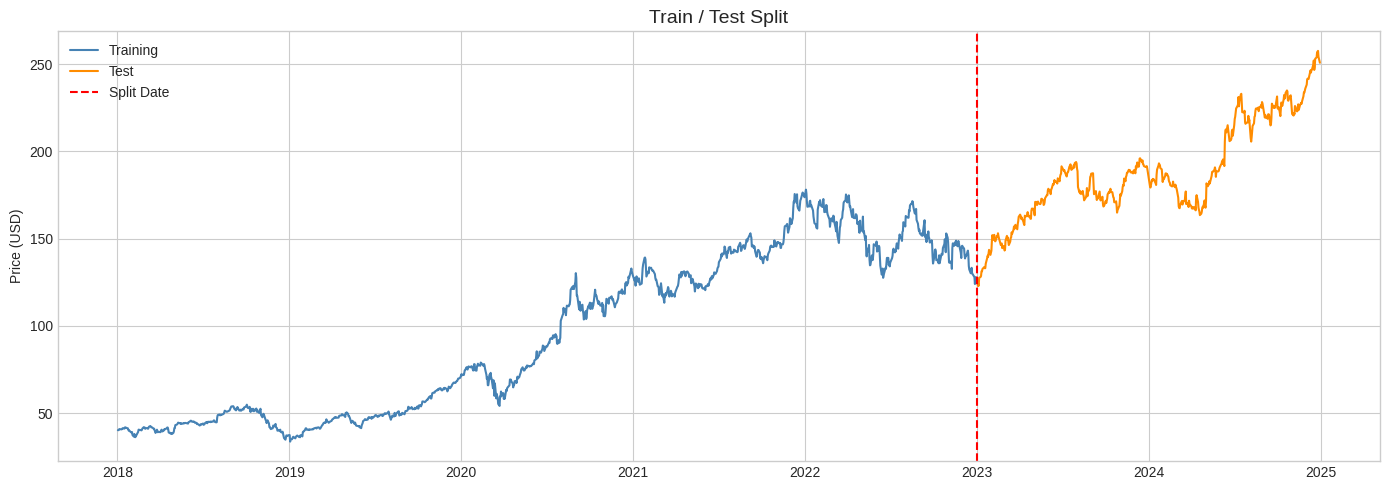

In [19]:
# ── 4.1 Chronological Train/Test Split ───────────────────────────────────────

SPLIT_DATE = "2023-01-01"   # Last ~2 years = test set

train = df["price"][:SPLIT_DATE]
test  = df["price"][SPLIT_DATE:]

print(f"Training set : {train.index.min().date()} → {train.index.max().date()} ({len(train)} days)")
print(f"Test set     : {test.index.min().date()}  → {test.index.max().date()} ({len(test)} days)")

# Visualise the split
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train.index, train, label="Training", color="steelblue")
ax.plot(test.index,  test,  label="Test",     color="darkorange")
ax.axvline(pd.Timestamp(SPLIT_DATE), color="red", linestyle="--", label="Split Date")
ax.set_title("Train / Test Split", fontsize=14)
ax.set_ylabel("Price (USD)")
ax.legend()
plt.tight_layout()
plt.show()


### 4.2 Fill-in-the-Blank: Fit ARIMA

In [20]:
# ── 4.2 Fit ARIMA(1,1,1) ─────────────────────────────────────────────────────
# FILL IN: complete the ARIMA call with order=(p, d, q)
# We determined d=1 from our ADF test. Start with p=1, q=1.

from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress the date frequency warning — yfinance indices are irregular
# due to market holidays and cannot be assigned a strict frequency
warnings.filterwarnings("ignore", category=ValueWarning)

arima_model = ARIMA(train, order=(1,1,1))
arima_result = arima_model.fit()

print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2757.331
Date:                Sat, 28 Feb 2026   AIC                           5520.661
Time:                        21:03:09   BIC                           5536.073
Sample:                             0   HQIC                          5526.453
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3930      0.247      1.591      0.112      -0.091       0.877
ma.L1         -0.4548      0.242     -1.883      0.060      -0.928       0.019
sigma2         4.6917      0.113     41.385      0.0

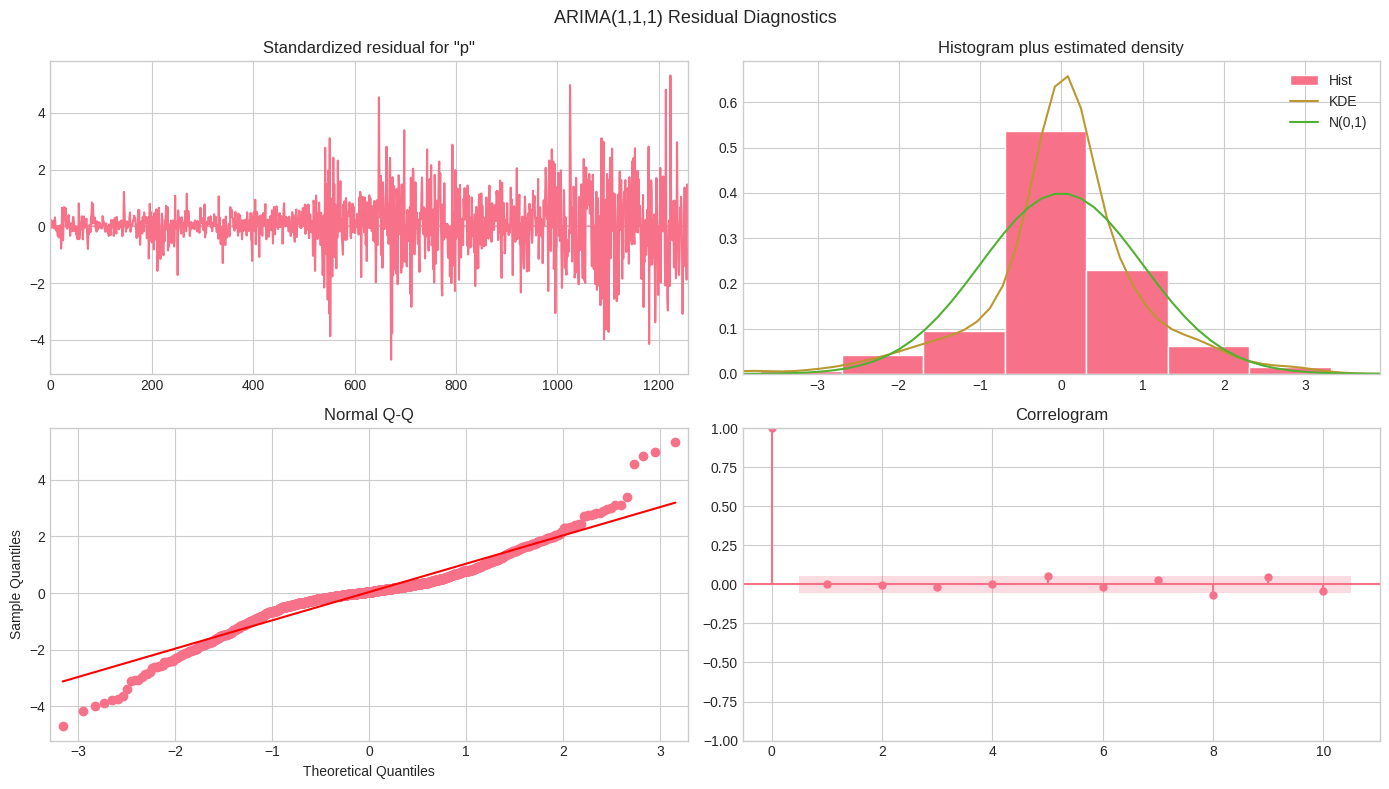


Ljung-Box Test (H0: residuals are white noise):
    lb_stat  lb_pvalue
10  10.1640     0.4262
20  21.3921     0.3744

→ p > 0.05 at all lags = ✅ residuals look like white noise (good fit)


In [21]:
# ── 4.3 Residual Diagnostics ─────────────────────────────────────────────────
# A well-fit ARIMA leaves residuals that look like white noise (random, no pattern)

arima_result.plot_diagnostics(figsize=(14, 8))
plt.suptitle("ARIMA(1,1,1) Residual Diagnostics", fontsize=13)
plt.tight_layout()
plt.show()

# Formal test: Ljung-Box test for residual autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(arima_result.resid, lags=[10, 20], return_df=True)
print("\nLjung-Box Test (H0: residuals are white noise):")
print(lb_result)
print("\n→ p > 0.05 at all lags = ✅ residuals look like white noise (good fit)")


In [22]:
# ── 4.4 Walk-Forward Validation (Rolling Forecast) ────────────────────────────
# This is the gold-standard evaluation for time series.
# At each step: fit on all available history, predict one step ahead, move forward.
# This avoids look-ahead bias — a common mistake in industry.

print("Running walk-forward validation (this may take a minute)...")

history     = list(train)
predictions = []
actuals     = list(test)

for i, actual in enumerate(actuals):
    model = ARIMA(history, order=(1, 1, 1))
    fit   = model.fit()
    yhat  = fit.forecast(steps=1)[0]
    predictions.append(yhat)
    history.append(actual)   # Add real observation to history
    if i % 50 == 0:
        print(f"  Step {i+1}/{len(actuals)} — predicted: {yhat:.2f}, actual: {actual:.2f}")

predictions = np.array(predictions)
actuals     = np.array(actuals)

# ── Metrics ───────────────────────────────────────────────────────────────────
mae  = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

print(f"\n{'='*40}")
print(f"ARIMA(1,1,1) Walk-Forward Results")
print(f"{'='*40}")
print(f"  MAE  : ${mae:.2f}")
print(f"  RMSE : ${rmse:.2f}")
print(f"  MAPE : {mape:.2f}%")


Running walk-forward validation (this may take a minute)...
  Step 1/501 — predicted: 127.83, actual: 123.10
  Step 51/501 — predicted: 150.72, actual: 153.62
  Step 101/501 — predicted: 170.72, actual: 173.16
  Step 151/501 — predicted: 177.62, actual: 175.89
  Step 201/501 — predicted: 173.90, actual: 173.43
  Step 251/501 — predicted: 190.59, actual: 183.73
  Step 301/501 — predicted: 169.62, actual: 171.44
  Step 351/501 — predicted: 185.57, actual: 188.52
  Step 401/501 — predicted: 205.79, actual: 208.21
  Step 451/501 — predicted: 230.26, actual: 230.63
  Step 501/501 — predicted: 254.24, actual: 250.83

ARIMA(1,1,1) Walk-Forward Results
  MAE  : $1.89
  RMSE : $2.55
  MAPE : 1.02%


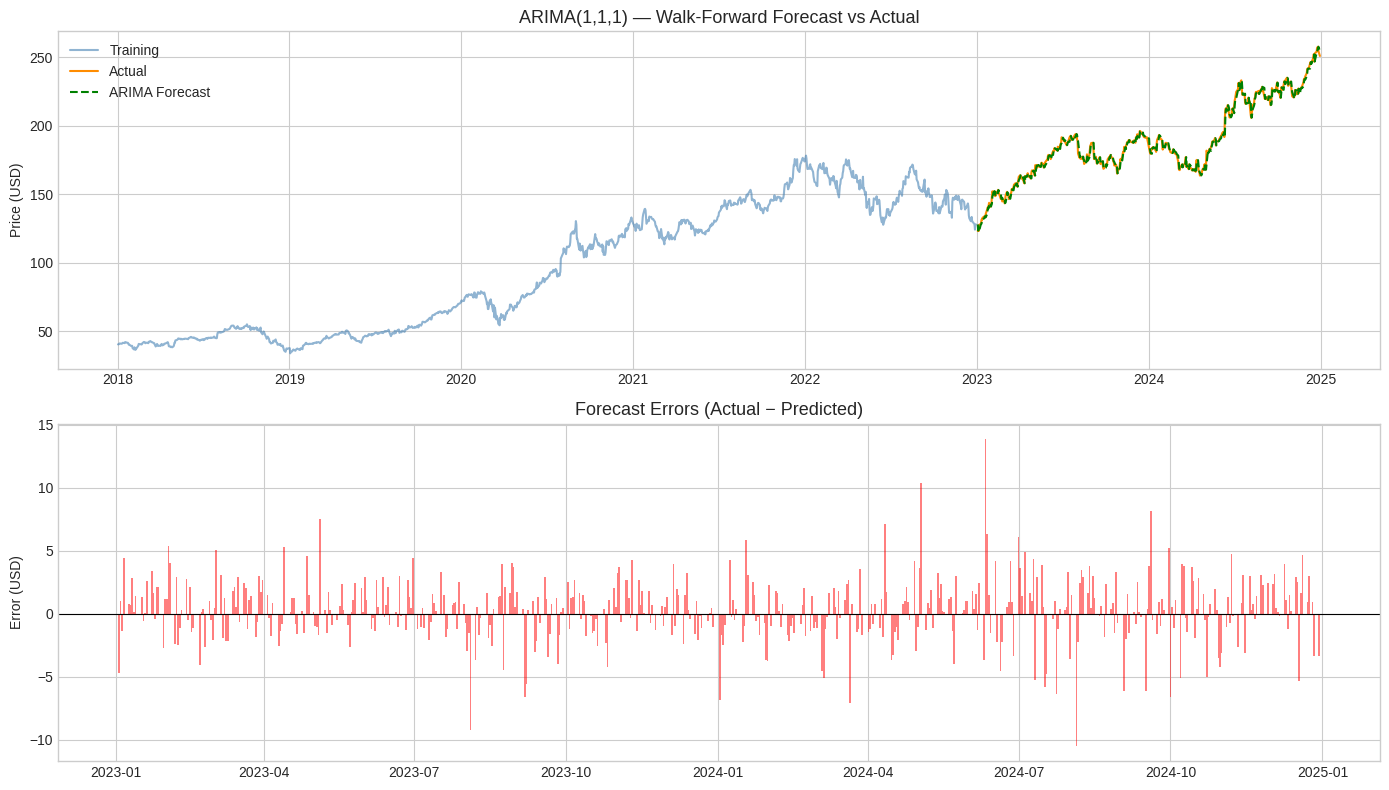

In [23]:
# ── 4.5 Plot Actual vs Predicted ─────────────────────────────────────────────

pred_series = pd.Series(predictions, index=test.index)

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(train.index, train, label="Training",   color="steelblue",   alpha=0.6)
axes[0].plot(test.index,  test,  label="Actual",     color="darkorange",  linewidth=1.5)
axes[0].plot(test.index,  pred_series, label="ARIMA Forecast",
             color="green", linewidth=1.5, linestyle="--")
axes[0].set_title("ARIMA(1,1,1) — Walk-Forward Forecast vs Actual", fontsize=13)
axes[0].set_ylabel("Price (USD)")
axes[0].legend()

# Error plot
errors = actuals - predictions
axes[1].bar(test.index, errors, color="red", alpha=0.5, width=1)
axes[1].axhline(0, color="black", linewidth=0.8)
axes[1].set_title("Forecast Errors (Actual − Predicted)", fontsize=13)
axes[1].set_ylabel("Error (USD)")

plt.tight_layout()
plt.show()

# Store for later comparison
arima_metrics = {"Model": "ARIMA(1,1,1)", "MAE": mae, "RMSE": rmse, "MAPE%": mape}


### 💬 Discussion Question 4A
> 1. Look at the model summary from Section 4.2. What do the AR and MA coefficients tell you? Are they statistically significant?
> 2. Walk-forward validation is more computationally expensive than a single train/test split. When is the extra cost justified in a production system?
> 3. ARIMA essentially predicts "the next value will be close to today's value plus a small correction." Given this, what do you think the fundamental limitation of ARIMA is for longer-horizon forecasting?

**Write your answers below:**

1. The AR(1) coefficient (0.39) and MA(1) coefficient (0.45) lack strong statistical significance at a 5% significance level, given that the p-values are ~0.11 and ~0.06, respectively. This implies that the autoregressive and moving average terms are not strong. In fact, the process behaves almost like an ARIMA(0,1,0), which implies that the process behaves like a random walk.

2. Walk-forward validation is warranted if:

	•	The model will be re-trained continuously in production.

	•	The process is non-stationary, so parameters may change over time.

	•	The cost of bad predictions is high.
  
	•Avoiding look-ahead bias is important.

In production forecasting systems, where the decisions cost money or other operational risks, the extra computational cost is warranted because it offers a much more realistic estimate of how the model will perform in production.
3.


---
## Section 5 — Time Series as Supervised Learning with `sklearn` 🤖

Here is a paradigm shift that connects directly to last week's lecture on supervised learning. **You can reframe any time series forecasting problem as a supervised regression problem** by engineering lag features.

The idea: if `price[t]` depends on `price[t-1], price[t-2], ..., price[t-n]`, then those lagged values become features `X` and `price[t]` becomes the target `y`. Now you can use any sklearn model you already know.

This is called the **"sliding window" or "lag feature" approach** and is widely used in production ML systems.

### 5.1 Feature Engineering


In [24]:
# ── 5.1 Engineer Lag Features ─────────────────────────────────────────────────

def make_lag_features(series, lags=20, target_col="price"):
    """
    Convert a time series into a supervised learning dataset.

    Parameters:
        series     : pd.Series of closing prices
        lags       : number of lagged time steps to use as features
        target_col : name for the target column

    Returns:
        pd.DataFrame with lag features + target
    """
    data = pd.DataFrame(series.copy())
    data.columns = [target_col]

    for lag in range(1, lags + 1):
        data[f"lag_{lag}"] = data[target_col].shift(lag)

    # Additional engineered features
    data["rolling_mean_5"]  = data[target_col].shift(1).rolling(5).mean()
    data["rolling_mean_20"] = data[target_col].shift(1).rolling(20).mean()
    data["rolling_std_5"]   = data[target_col].shift(1).rolling(5).std()
    data["day_of_week"]     = data.index.dayofweek
    data["month"]           = data.index.month

    return data.dropna()

feat_df = make_lag_features(df["price"], lags=20)

print(f"Feature matrix shape: {feat_df.shape}")
print(f"Features: {list(feat_df.columns)}")
feat_df.head()


Feature matrix shape: (1740, 26)
Features: ['price', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'rolling_mean_5', 'rolling_mean_20', 'rolling_std_5', 'day_of_week', 'month']


,price,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean_5,rolling_mean_20,rolling_std_5,day_of_week,month
date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,39.1741,39.0665,39.2981,40.1287,40.0351,40.7628,41.4226,41.4132,41.7548,41.9420,...,40.7932,40.9453,40.4843,40.2972,40.3042,39.8582,40.7894,0.6825,2,1
2018-02-01,39.2560,39.1741,39.0665,39.2981,40.1287,40.0351,40.7628,41.4226,41.4132,41.7548,...,40.7885,40.7932,40.9453,40.4843,40.2972,39.5405,40.7329,0.5021,3,2
2018-02-02,37.5527,39.2560,39.1741,39.0665,39.2981,40.1287,40.0351,40.7628,41.4226,41.4132,...,40.7791,40.7885,40.7932,40.9453,40.4843,39.3847,40.6809,0.4252,4,2
2018-02-05,36.6144,37.5527,39.2560,39.1741,39.0665,39.2981,40.1287,40.0351,40.7628,41.4226,...,41.0108,40.7791,40.7885,40.7932,40.9453,38.8695,40.5343,0.7414,0,2
2018-02-06,38.1446,36.6144,37.5527,39.2560,39.1741,39.0665,39.2981,40.1287,40.0351,40.7628,...,41.4343,41.0108,40.7791,40.7885,40.7932,38.3327,40.3177,1.1895,1,2


In [ ]:
# ── 5.2 Chronological Train/Test Split (no shuffling!) ────────────────────────

feature_cols = [c for c in feat_df.columns if c != "price"]

X = feat_df[feature_cols]
y = feat_df["price"]

split_idx   = feat_df.index.searchsorted(pd.Timestamp(SPLIT_DATE))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"X_train: {X_train.shape}  |  X_test: {X_test.shape}")


In [ ]:
# ── 5.3 Linear Regression (Baseline) ─────────────────────────────────────────

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

lr_mae  = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mape = np.mean(np.abs((y_test.values - lr_preds) / y_test.values)) * 100
lr_r2   = r2_score(y_test, lr_preds)

print(f"Linear Regression on Lag Features")
print(f"  MAE  : ${lr_mae:.2f}")
print(f"  RMSE : ${lr_rmse:.2f}")
print(f"  MAPE : {lr_mape:.2f}%")
print(f"  R²   : {lr_r2:.4f}")


In [ ]:
# ── 5.4 Random Forest (Non-linear Model) ─────────────────────────────────────

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

rf_mae  = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mape = np.mean(np.abs((y_test.values - rf_preds) / y_test.values)) * 100
rf_r2   = r2_score(y_test, rf_preds)

print(f"Random Forest on Lag Features")
print(f"  MAE  : ${rf_mae:.2f}")
print(f"  RMSE : ${rf_rmse:.2f}")
print(f"  MAPE : {rf_mape:.2f}%")
print(f"  R²   : {rf_r2:.4f}")


In [ ]:
# ── 5.5 Feature Importance ────────────────────────────────────────────────────
# Random Forest gives us feature importances — a major advantage over ARIMA.

importances = pd.Series(rf.feature_importances_, index=feature_cols)
top_features = importances.nlargest(15)

fig, ax = plt.subplots(figsize=(10, 6))
top_features.sort_values().plot(kind="barh", ax=ax, color="steelblue")
ax.set_title("Random Forest — Top 15 Feature Importances", fontsize=13)
ax.set_xlabel("Importance")
plt.tight_layout()
plt.show()

print("Top 5 most predictive features:")
print(top_features.head())


In [ ]:
# ── 5.6 Compare LR vs RF vs ARIMA visually ───────────────────────────────────

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y_test.index, y_test.values,  label="Actual",     color="black",      linewidth=1.5)
ax.plot(y_test.index, lr_preds,       label="Lin. Reg.",  color="steelblue",  linewidth=1, linestyle="--")
ax.plot(y_test.index, rf_preds,       label="Rand. Forest", color="green",    linewidth=1, linestyle="-.")
ax.plot(test.index,   predictions,    label="ARIMA(1,1,1)", color="darkorange",linewidth=1, linestyle=":")
ax.set_title("Model Comparison — Test Period Forecasts", fontsize=14)
ax.set_ylabel("Price (USD)")
ax.legend()
plt.tight_layout()
plt.show()

# Tabulate metrics
sklearn_metrics = [
    {"Model": "Linear Regression (lag)", "MAE": lr_mae,  "RMSE": lr_rmse,  "MAPE%": lr_mape},
    {"Model": "Random Forest (lag)",     "MAE": rf_mae,  "RMSE": rf_rmse,  "MAPE%": rf_mape},
]
metrics_table = pd.DataFrame([arima_metrics] + sklearn_metrics)
metrics_table = metrics_table.set_index("Model")
print("\nModel Comparison Table:")
print(metrics_table.to_string())


### 💬 Discussion Question 5A
> 1. Why might Random Forest achieve a high R² score on this problem even though predicting stock prices is notoriously difficult? Is high R² always a sign of a good model?
> 2. The feature importance plot likely shows that `lag_1` dominates. What does this tell you about the nature of stock price movements? How does this relate to the Efficient Market Hypothesis?
> 3. If you were presenting these models to a portfolio manager at a hedge fund, which would you choose and why? What additional information would they likely demand before trusting the model?

**Write your answers below:**

1.
2.
3.


---
## Section 6 — Forecasting with `Prophet` 🔮

**Prophet** was developed by Meta's Core Data Science team and released as open source in 2017. It is designed for analysts who need reliable forecasts quickly, without deep time series expertise. It is widely used in industry for:

- Business metric forecasting (DAU, revenue, inventory)
- Capacity planning
- Anomaly detection baselines

**Key advantages:**
- Handles missing data and outliers automatically
- Models trend, weekly seasonality, yearly seasonality, and holidays out of the box
- Interpretable components
- Uncertainty intervals built in

Prophet expects a DataFrame with exactly two columns: `ds` (datestamp) and `y` (value). That's it.


In [ ]:
# ── 6.1 Prepare Prophet Data ──────────────────────────────────────────────────

prophet_df = df["price"].reset_index()
prophet_df.columns = ["ds", "y"]
prophet_df["ds"] = pd.to_datetime(prophet_df["ds"])

# Remove timezone info if present
if prophet_df["ds"].dt.tz is not None:
    prophet_df["ds"] = prophet_df["ds"].dt.tz_localize(None)

prophet_train = prophet_df[prophet_df["ds"] < SPLIT_DATE]
prophet_test  = prophet_df[prophet_df["ds"] >= SPLIT_DATE]

print(f"Prophet train shape : {prophet_train.shape}")
print(f"Prophet test shape  : {prophet_test.shape}")
prophet_train.tail()


In [ ]:
# ── 6.2 Fit Prophet Model ─────────────────────────────────────────────────────

prophet_model = Prophet(
    daily_seasonality   = False,
    weekly_seasonality  = True,
    yearly_seasonality  = True,
    changepoint_prior_scale = 0.05,   # Controls flexibility of trend
    seasonality_prior_scale = 10,     # Controls flexibility of seasonality
    interval_width      = 0.95,       # 95% uncertainty intervals
)

# Add US stock market holidays
prophet_model.add_country_holidays(country_name="US")

print("Fitting Prophet model...")
prophet_model.fit(prophet_train)
print("✅ Prophet model fitted.")


In [ ]:
# ── 6.3 Generate Forecast ─────────────────────────────────────────────────────

# Create a future dataframe for the test period + 90 additional days
future = prophet_model.make_future_dataframe(
    periods = len(prophet_test) + 90,
    freq    = "B"   # "B" = business days only
)

forecast = prophet_model.predict(future)
forecast_test = forecast[forecast["ds"] >= SPLIT_DATE]

print(f"Forecast columns: {list(forecast.columns)}")
forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "trend", "weekly", "yearly"]].tail(10)


In [ ]:
# ── 6.4 Evaluation on Test Set ────────────────────────────────────────────────

# Align test actuals with prophet predictions
prophet_test_merged = prophet_test.merge(
    forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]],
    on="ds", how="inner"
)

p_mae  = mean_absolute_error(prophet_test_merged["y"], prophet_test_merged["yhat"])
p_rmse = np.sqrt(mean_squared_error(prophet_test_merged["y"], prophet_test_merged["yhat"]))
p_mape = np.mean(np.abs((prophet_test_merged["y"] - prophet_test_merged["yhat"])
                          / prophet_test_merged["y"])) * 100

print(f"Prophet Forecast Evaluation")
print(f"  MAE  : ${p_mae:.2f}")
print(f"  RMSE : ${p_rmse:.2f}")
print(f"  MAPE : {p_mape:.2f}%")

prophet_metrics = {"Model": "Prophet", "MAE": p_mae, "RMSE": p_rmse, "MAPE%": p_mape}


In [ ]:
# ── 6.5 Prophet Component Plots ───────────────────────────────────────────────
# These plots are one of Prophet's most valuable features — they decompose the
# forecast into interpretable components.

fig = prophet_model.plot_components(forecast)
plt.suptitle("Prophet — Forecast Components", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ── 6.6 Full Forecast Plot with Uncertainty Intervals ─────────────────────────

fig, ax = plt.subplots(figsize=(14, 6))

# Historical
ax.plot(prophet_train["ds"], prophet_train["y"],
        color="steelblue", label="Training", alpha=0.7, linewidth=1)

# Test actuals
ax.plot(prophet_test_merged["ds"], prophet_test_merged["y"],
        color="black", label="Actual (test)", linewidth=1.5)

# Prophet forecast
ax.plot(forecast_test["ds"], forecast_test["yhat"],
        color="darkorange", label="Prophet Forecast", linewidth=1.5, linestyle="--")

# Uncertainty band
ax.fill_between(forecast_test["ds"],
                forecast_test["yhat_lower"],
                forecast_test["yhat_upper"],
                alpha=0.2, color="darkorange", label="95% CI")

# 90-day future
future_only = forecast[forecast["ds"] > prophet_df["ds"].max()]
ax.plot(future_only["ds"], future_only["yhat"],
        color="green", linewidth=1.5, linestyle="-.", label="90-day Ahead Forecast")
ax.fill_between(future_only["ds"],
                future_only["yhat_lower"], future_only["yhat_upper"],
                alpha=0.15, color="green")

ax.axvline(pd.Timestamp(SPLIT_DATE), color="red", linestyle="--", alpha=0.7, label="Split Date")
ax.set_title(f"Prophet Forecast — {TICKER}", fontsize=14)
ax.set_ylabel("Price (USD)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# ── 6.7 Final Model Comparison Table ─────────────────────────────────────────

all_metrics = pd.DataFrame([
    arima_metrics,
    {"Model": "Linear Regression (lag)", "MAE": lr_mae,  "RMSE": lr_rmse,  "MAPE%": lr_mape},
    {"Model": "Random Forest (lag)",     "MAE": rf_mae,  "RMSE": rf_rmse,  "MAPE%": rf_mape},
    prophet_metrics,
]).set_index("Model").round(2)

print("\n" + "="*55)
print("    COMPLETE MODEL COMPARISON TABLE")
print("="*55)
print(all_metrics.to_string())
print("\n→ Lower MAE / RMSE / MAPE% = better forecast accuracy")


### 💬 Discussion Question 6A
> 1. Prophet's uncertainty intervals (the shaded region) widen as you forecast further into the future. Why? What are the practical implications for a business relying on 90-day forecasts?
> 2. The weekly and yearly seasonality components in the Prophet decomposition may look surprising for a stock. What economic or behavioral factors could explain weekly patterns in stock prices?
> 3. Looking at the final comparison table: if you had to choose ONE model to deploy in a production system that generates daily forecasts automatically, which would you choose and what criteria drove that decision beyond raw accuracy metrics?

**Write your answers below:**

1.
2.
3.


---
## Section 7 — Agentic Forecasting Pipeline with Smolagents + GROQ + HuggingFace 🤖🧠

This is where everything comes together. We now build an **AI agent** that:

1. Accepts a stock ticker as input
2. Downloads and analyzes the time series
3. Runs a stationarity check
4. Fits an ARIMA model
5. Generates a 30-day forecast
6. Narrates the results in plain English using an LLM (via GROQ or HuggingFace)

This mirrors a real **MLOps agentic pipeline** pattern — the kind you would build at a fintech firm, hedge fund, or data-driven enterprise.

### Architecture Overview

```
User Query
    │
    ▼
CodeAgent (Smolagents)
    │
    ├── Tool: fetch_and_analyze_series()
    ├── Tool: run_stationarity_check()
    ├── Tool: fit_arima_forecast()
    └── Tool: summarize_with_llm()  ←── GROQ / HuggingFace
```




### 7.1 Define Agent Tools

In [ ]:
# ── 7.1 Define Smolagents Tools ───────────────────────────────────────────────
# Each @tool is a self-contained callable the agent can invoke.
# Type hints and docstrings are essential — the agent reads them to understand
# what each tool does and when to use it.

@tool
def fetch_stock_data(ticker: str, start: str, end: str) -> str:
    """
    Fetches daily closing price data for a stock ticker from Yahoo Finance.
    Returns a summary string with basic statistics about the time series.

    Args:
        ticker: Stock ticker symbol (e.g., 'AAPL', 'SPY', 'MSFT')
        start:  Start date in YYYY-MM-DD format
        end:    End date in YYYY-MM-DD format
    """
    import yfinance as yf
    import numpy as np

    data = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    if data.empty:
        return f"ERROR: No data found for {ticker}."

    close = data["Close"].squeeze()
    returns = close.pct_change().dropna()

    summary = (
        f"Ticker: {ticker}\n"
        f"Date Range: {close.index.min().date()} to {close.index.max().date()}\n"
        f"Observations: {len(close)}\n"
        f"Price Range: ${close.min():.2f} – ${close.max():.2f}\n"
        f"Mean Price: ${close.mean():.2f}\n"
        f"Std Dev: ${close.std():.2f}\n"
        f"Mean Daily Return: {returns.mean()*100:.4f}%\n"
        f"Return Volatility (annualized): {returns.std()*np.sqrt(252)*100:.2f}%\n"
        f"Total Return over period: {((close.iloc[-1]/close.iloc[0])-1)*100:.2f}%"
    )
    return summary


@tool
def run_stationarity_check(ticker: str, start: str, end: str) -> str:
    """
    Downloads stock data and runs an Augmented Dickey-Fuller stationarity test.
    Returns the test result and recommended differencing order.

    Args:
        ticker: Stock ticker symbol
        start:  Start date in YYYY-MM-DD format
        end:    End date in YYYY-MM-DD format
    """
    import yfinance as yf
    from statsmodels.tsa.stattools import adfuller

    data  = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    close = data["Close"].squeeze().dropna()

    result_raw  = adfuller(close)
    result_diff = adfuller(close.diff().dropna())

    d = 0 if result_raw[1] < 0.05 else 1

    report = (
        f"ADF Test — {ticker} Raw Price:\n"
        f"  p-value: {result_raw[1]:.6f} → {'STATIONARY' if result_raw[1]<0.05 else 'NON-STATIONARY'}\n\n"
        f"ADF Test — {ticker} First Difference:\n"
        f"  p-value: {result_diff[1]:.6f} → {'STATIONARY' if result_diff[1]<0.05 else 'NON-STATIONARY'}\n\n"
        f"Recommended d (differencing order): {d}"
    )
    return report


@tool
def fit_arima_and_forecast(ticker: str, start: str, end: str,
                            p: int, d: int, q: int, forecast_days: int) -> str:
    """
    Fits an ARIMA(p,d,q) model to stock closing prices and generates a forecast.
    Returns a text summary of model performance and future price predictions.

    Args:
        ticker:        Stock ticker symbol
        start:         Training data start date (YYYY-MM-DD)
        end:           Training data end date (YYYY-MM-DD)
        p:             AR order
        d:             Differencing order (use result from stationarity check)
        q:             MA order
        forecast_days: Number of trading days to forecast ahead
    """
    import yfinance as yf
    import numpy as np
    from statsmodels.tsa.arima.model import ARIMA

    data  = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    close = data["Close"].squeeze().dropna()

    model  = ARIMA(close, order=(p, d, q))
    result = model.fit()

    forecast    = result.forecast(steps=forecast_days)
    conf_int    = result.get_forecast(steps=forecast_days).conf_int(alpha=0.05)
    last_price  = close.iloc[-1]

    forecast_lines = []
    for i, (yhat, (lo, hi)) in enumerate(zip(forecast, conf_int.values), 1):
        forecast_lines.append(
            f"  Day +{i:02d}: ${yhat:.2f}  (95% CI: ${lo:.2f} – ${hi:.2f})"
        )

    report = (
        f"ARIMA({p},{d},{q}) Model — {ticker}\n"
        f"{'='*50}\n"
        f"AIC: {result.aic:.2f}  |  BIC: {result.bic:.2f}\n"
        f"Last Observed Price: ${last_price:.2f}\n\n"
        f"{forecast_days}-Day Ahead Forecast:\n"
        + "\n".join(forecast_lines[:10])   # Cap at 10 lines for readability
        + f"\n  ...\n  Day +{forecast_days}: ${forecast.iloc[-1]:.2f}"
        + f"\n\nImplied {forecast_days}-day Return: "
        + f"{((forecast.iloc[-1]/last_price)-1)*100:.2f}%"
    )
    return report

print("✅ All agent tools defined.")
print("   Tools available: fetch_stock_data, run_stationarity_check, fit_arima_and_forecast")


### 7.2 Initialize the LLM Backbone

We will demonstrate both GROQ and HuggingFace as LLM providers. This is a real industry skill — knowing how to swap model backends without rewriting your agentic code.


In [ ]:
# ── 7.2a GROQ Backend ─────────────────────────────────────────────────────────
# GROQ provides blazing-fast inference of open-source LLMs (Llama 3, Mixtral, etc.)
# Free tier: ~14,400 requests/day with no credit card required

from smolagents import OpenAIServerModel, InferenceClientModel, CodeAgent

# GROQ uses an OpenAI-compatible REST API — use OpenAIServerModel, not HfApiModel
groq_model = OpenAIServerModel(
    model_id = "llama-3.3-70b-versatile",          # GROQ model name (not HF path)
    api_base = "https://api.groq.com/openai/v1",
    api_key  = GROQ_API_KEY,
)

print("✅ GROQ backend initialized.")
print("   Model: llama-3.3-70b-versatile via GROQ")


In [ ]:
# ── 7.2b HuggingFace Backend ──────────────────────────────────────────────────
# HuggingFace Inference API provides free access to thousands of open-source models
# No API key required for many smaller models; free tier available

hf_model = InferenceClientModel(
    model_id = "Qwen/Qwen2.5-72B-Instruct",   # Strong open-source model, free tier
    token    = HF_TOKEN,
)

print("✅ HuggingFace backend initialized.")
print("   Model: Qwen/Qwen2.5-72B-Instruct via HuggingFace Inference API")


### 7.3 Build and Run the Forecasting Agent

Now we assemble the full agentic pipeline. The `CodeAgent` will reason over our tools, decide which to call, interpret the results, and produce a final narrative.


In [ ]:
# ── 7.3 Create the Smolagents CodeAgent ───────────────────────────────────────
# CodeAgent reasons by writing and executing Python code, then using
# the tool results to form a final answer. This is more powerful than
# a simple ReAct agent for data science tasks.

# Re-run this before the CodeAgent cell if agent_tools is undefined
agent_tools = [
    fetch_stock_data,
    run_stationarity_check,
    fit_arima_and_forecast,
]

print([t.name for t in agent_tools])   # Should print the three tool names

forecasting_agent = CodeAgent(
    tools          = agent_tools,
    model          = groq_model,    # ← swap to hf_model for HuggingFace
    max_steps      = 8,
    verbosity_level = 2,            # 0=silent, 1=minimal, 2=full reasoning steps
)

print("✅ Forecasting agent ready.")
print("   Agent type  : CodeAgent")
print("   Tools bound :", [t.name for t in agent_tools])


In [ ]:
# ── 7.4 Run the Agent ─────────────────────────────────────────────────────────
# This is the key moment — we give the agent a natural language task and let it
# reason, call tools, and synthesize a response autonomously.

AGENT_QUERY = f"""
You are a senior quantitative analyst. Analyze the stock {TICKER} using the following steps:

1. Fetch and summarize the stock data from 2018-01-01 to 2024-12-31.
2. Run a stationarity test and determine the appropriate differencing order (d).
3. Fit an ARIMA(1, d, 1) model and generate a 30-day ahead price forecast.
4. Write a concise, professional analyst report (3–5 paragraphs) summarizing:
   - Key statistics and trend observations
   - Stationarity findings and what they mean for modeling
   - The 30-day forecast and implied return
   - One risk caveat a portfolio manager should be aware of
   - A clear bottom-line recommendation

Write in the style of a Bloomberg Intelligence analyst note.
"""

print("🤖 Agent starting analysis...\n")
print("="*60)

agent_report = forecasting_agent.run(AGENT_QUERY)

print("\n" + "="*60)
print("📋 FINAL AGENT REPORT")
print("="*60)
print(agent_report)


### 7.4 Swap Backends — HuggingFace Edition

One of the most important architectural principles in modern ML systems is **provider abstraction** — your pipeline should not be locked into one vendor. Below we re-run the agent with the HuggingFace backend so you can compare outputs.


In [ ]:
# ── 7.5 Re-run with HuggingFace Backend ──────────────────────────────────────

forecasting_agent_hf = CodeAgent(
    tools           = agent_tools,
    model           = hf_model,
    max_steps       = 8,
    verbosity_level = 0,    # Set to 2 to see full reasoning steps
)

print("🤖 HuggingFace agent starting analysis...\n")
hf_report = forecasting_agent_hf.run(AGENT_QUERY)

print("\n" + "="*60)
print("📋 HUGGINGFACE AGENT REPORT")
print("="*60)
print(hf_report)


### 7.5 Direct LLM Comparison (GROQ vs HuggingFace)

Beyond using the agent, you can also call GROQ and HuggingFace directly for pure text generation tasks. This is useful when you have already computed your results and just need the LLM to narrate them.


In [ ]:
# ── 7.6 Direct GROQ API call ──────────────────────────────────────────────────
# This uses the Groq Python client directly — no agent overhead.
# Use this pattern when you have structured results and just need narration.

from groq import Groq as GroqClient

groq_client = GroqClient(api_key=GROQ_API_KEY)

# Prepare a structured prompt from our computed metrics
metrics_text = all_metrics.to_string()

groq_chat = groq_client.chat.completions.create(
    model    = "llama-3.3-70b-versatile",
    messages = [
        {
            "role": "system",
            "content": (
                "You are a senior data scientist writing for a financial audience. "
                "Be concise, precise, and use correct statistical terminology."
            )
        },
        {
            "role": "user",
            "content": (
                f"Here are the results from four forecasting models applied to {TICKER} stock:\n\n"
                f"{metrics_text}\n\n"
                "In 3 sentences, explain which model performed best, why that might be, "
                "and what a practitioner should consider before deploying any of these models in production."
            )
        }
    ],
    temperature = 0.3,
    max_tokens  = 400,
)

print("GROQ Direct Response:")
print("─" * 50)
print(groq_chat.choices[0].message.content)


In [ ]:
# ── 7.7 Direct HuggingFace Inference API call ────────────────────────────────
# InferenceClient is the standard HuggingFace SDK for calling hosted models.

from huggingface_hub import InferenceClient

hf_client = InferenceClient(token=HF_TOKEN)

hf_response = hf_client.chat_completion(
    model    = "Qwen/Qwen2.5-72B-Instruct",
    messages = [
        {
            "role": "system",
            "content": "You are a concise financial data science assistant."
        },
        {
            "role": "user",
            "content": (
                f"Model comparison for {TICKER} forecasting:\n{metrics_text}\n\n"
                "In 3 sentences: which model wins, likely reason, and one production caveat."
            )
        }
    ],
    max_tokens  = 400,
    temperature = 0.3,
)

print("HuggingFace Direct Response:")
print("─" * 50)
print(hf_response.choices[0].message.content)


### 💬 Discussion Question 7A — The Big Picture

> These are the capstone questions for this workshop. Take your time. These are the types of questions you may face in a final-round data science interview.

> 1. **Agentic Design:** Our agent used three tools. If you were extending this pipeline for a production trading desk, what additional tools would you add? Think about data sources, risk checks, and compliance requirements.

> 2. **LLM Provider Trade-offs:** You just ran the same task on GROQ and HuggingFace. What differences did you observe in speed, output quality, and reasoning style? In a production system, what factors would determine which provider you choose?

> 3. **The Limits of Forecasting:** All four models were applied to a financial time series. Stock price prediction is widely considered one of the hardest forecasting problems. Given everything you have built today, what is your honest assessment of the practical utility of these models? Under what conditions might they genuinely add value?

> 4. **Connecting to Last Week:** How does the agentic pipeline we built today relate to the federated learning paradigm discussed last week? Could you imagine a federated forecasting agent? What would that look like and what problem would it solve?

> 5. **Capstone Connection:** How could you apply the techniques in this notebook to your own final project? Identify one specific component — a tool, a model, or an agentic pattern — that you could adapt for your research.

**Write your answers below (double-click to edit):**

1.

2.

3.

4.

5.


---
## 🎓 Workshop Summary

Congratulations — you have built a complete, industry-grade time series forecasting and agentic pipeline. Here is what you accomplished today:

| Section | What You Built | Industry Skill |
|---------|---------------|----------------|
| 1 | Reproducible environment setup | Dependency management |
| 2 | Live financial data acquisition + EDA | `yfinance`, exploratory analysis |
| 3 | Stationarity testing + decomposition | ADF test, ACF/PACF interpretation |
| 4 | ARIMA with walk-forward validation | Classical time series modeling |
| 5 | Lag-feature regression (LR + RF) | Supervised ML on time series |
| 6 | Prophet with uncertainty intervals | Production-grade forecasting |
| 7 | Agentic pipeline (GROQ + HuggingFace) | LLM orchestration, tool use, MLOps |

### Key Interview Concepts to Remember

- **Stationarity is a prerequisite**, not a suggestion. Always ADF-test first.
- **Never randomly split time series** — always chronological splits.
- **Walk-forward validation** is the gold standard for time series evaluation.
- **Lag features** are the bridge between time series and supervised learning.
- **Agentic pipelines** are the future of production ML — tools + LLMs + orchestration.
- **Provider abstraction** — your code should not be locked to one LLM vendor.

### 📚 Further Reading
- Box, Jenkins et al. — *Time Series Analysis: Forecasting and Control* (the ARIMA bible)
- Taylor & Letham — *Forecasting at Scale* (the original Prophet paper, 2018)
- Sutton & Barto — *Reinforcement Learning* (connects to last week's paradigms)
- HuggingFace Smolagents docs — [huggingface.co/docs/smolagents](https://huggingface.co/docs/smolagents)
- GROQ docs — [console.groq.com/docs](https://console.groq.com/docs)
